# **Fake News Detector**

## Importing modules

In [1]:
import pandas as pd
import os
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

## Loading the Dataset

In [2]:
real = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

In [3]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Adding a label that indicates whether the news is fake or real.
**Real news is denoted using 1.
Fake news is denoted using 0.**

In [5]:
real['label'] = 1
fake['label'] = 0

Combining the two datasets and shuffling it.

In [6]:
news = pd.concat([real,fake])
news = news.sample(frac=1, random_state = 1).reset_index(drop = True)
news.head()

,title,text,subject,date,label
0,EPA chief says Paris climate agreement 'bad de...,WASHINGTON (Reuters) - The United States shoul...,politicsNews,"April 2, 2017",1
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,"Jul 26, 2017",0
2,Trump says New Hampshire win not necessary to ...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"February 7, 2016",1
3,Kremlin: U.S. sanctions aimed at turning busin...,MOSCOW (Reuters) - The Kremlin said on Thursda...,worldnews,"November 30, 2017",1
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,left-news,"Dec 27, 2016",0


In [7]:
news.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

We can see that our dataset has no null values.

In [8]:
news['text'] = news['title'] + ' ' + news['text']
news.drop(['title', 'subject','date'], inplace = True, axis = 1)
news.head()

,text,label
0,EPA chief says Paris climate agreement 'bad de...,1
1,BREAKING NEWS: President Trump Announces Major...,0
2,Trump says New Hampshire win not necessary to ...,1
3,Kremlin: U.S. sanctions aimed at turning busin...,1
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,0


In [9]:
news.shape

(44898, 2)

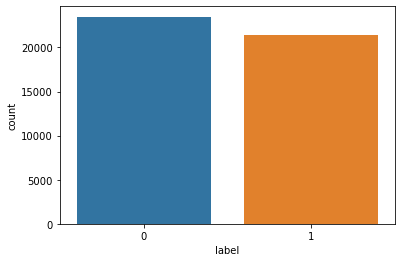

In [10]:
sns.countplot(news['label']);

From the above plot, we can see that our dataset is balanced.

## Text Preprocessing

Now, we are removing stop words, punctutations, and digits from the news text, and are performing Lemmatization.

In [11]:
nlp = spacy.load('en')

def clean_text(text):
    doc = nlp(text)
    clean = []
    for token in doc:
        if not token.is_punct and not token.is_space and not token.is_digit:
            if not token.is_stop:
                clean.append(token.lemma_.lower())
    return(' '.join(clean))

In [12]:
news['text'] = news['text'].apply(clean_text)
news.head()

,text,label
0,epa chief say paris climate agreement bad deal...,1
1,breaking news president trump announce major p...,0
2,trump say new hampshire win necessary secure n...,1
3,kremlin u.s. sanction aim turn business elite ...,1
4,watch kellyanne conway punch juan williams que...,0


## Word Clouds

### ***Word Cloud for the Fake news.***

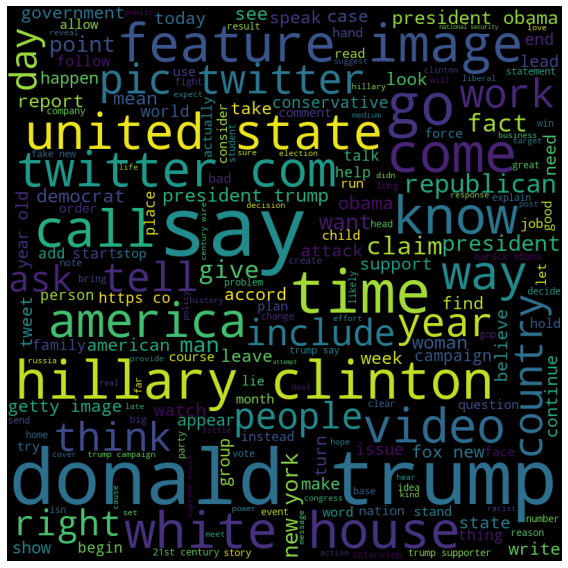

In [13]:
wordcloud = WordCloud(width = 800, height = 800, max_font_size = 120).generate(" ".join(news[news['label'] == 0].text)) 
                  
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout() 
plt.show() 

### ***Word Cloud for the Real news.***

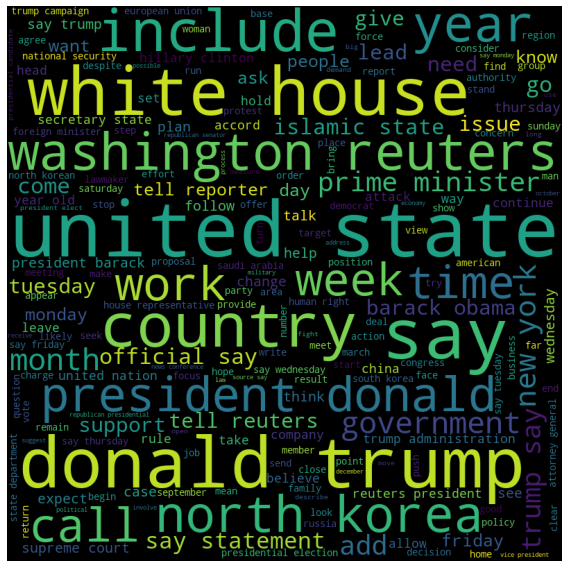

In [14]:
wordcloud = WordCloud(width = 800, height = 800, max_font_size = 120).generate(" ".join(news[news['label'] == 1].text)) 
                     
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout() 
plt.show() 

## Splitting the data for training and testing.

In [15]:
text_train, text_test, label_train, label_test = train_test_split(news['text'], news['label'], test_size = 0.2)

## **CountVectorizer and TF-IDF Transformer.**

We fit the CountVectorizer and TF-IDF Transformer on the training dataset, and transform on both training and testing dataset.

In [16]:
count_vectorizer = CountVectorizer()
freq_term_matrix = count_vectorizer.fit_transform(text_train)

In [17]:
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(freq_term_matrix)
print(tfidf_matrix.toarray().shape)

(35918, 102606)


In [18]:
test_count_vect = count_vectorizer.transform(text_test)
test_tfidf = tfidf.transform(test_count_vect)
print(test_tfidf.toarray().shape)

(8980, 102606)


## **Classification**

### ***Logistic Regression Model***

In [23]:
logreg = LogisticRegression(C=1e4, max_iter=300)
logreg.fit(tfidf_matrix,label_train)
predlogreg = logreg.predict(test_tfidf)
 
print('Confusion Matrix:')
print(confusion_matrix(label_test, predlogreg)) 
print('Accuracy Score:', accuracy_score(label_test, predlogreg))
print('Classification Report: ')
print(classification_report(label_test, predlogreg)) 

Confusion Matrix:
[[4661   21]
 [  19 4279]]
Accuracy Score: 0.9955456570155902
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4682
           1       1.00      1.00      1.00      4298

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### ***Naive Bayes Model***

In [24]:
nb = MultinomialNB()
nb.fit(tfidf_matrix,label_train)
prednb = nb.predict(test_tfidf)

print('Confusion Matrix:')
print(confusion_matrix(label_test, prednb)) 
print('Accuracy Score:',accuracy_score(label_test, prednb))
print('Classification Report: ')
print(classification_report(label_test, prednb))

Confusion Matrix:
[[4428  254]
 [ 309 3989]]
Accuracy Score: 0.9373051224944321
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4682
           1       0.94      0.93      0.93      4298

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



### We see that the Logistic Regression model performs better, with an accuracy score of 0.99, as compared to the Naive Bayes model that has an accuracy of 0.93. The False Negatives and False Positives are also much lower in the Logistic Regression model, as seen from the confusion matrix.
